# ResNet

This notebook is an implement of [___Deep Residual Learning for Image Recognition___](https://arxiv.org/pdf/1512.03385.pdf) by He et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and is better to store on server. 

We first need to install and import all the dependent libraries in the session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import keras_tuner

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-12-20 21:08:48.822364: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-20 21:09:29.588517: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-20 21:09:29.714647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-20 21:09:29.714682: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-20 21:09:29.741840: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-20 21:09:29.741895: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set.

In [2]:
def get_data():
    train, test = tfds.as_numpy(tfds.load("cifar10", split = ["train", "test"]
                                          , shuffle_files = True, as_supervised = True, batch_size = -1))
    
    return train[0], test[0], train[1], test[1]

train_x, test_x, train_y, test_y = get_data()

2021-12-20 21:09:30.813261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-20 21:09:30.815950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
2021-12-20 21:09:30.817481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-20 21:09:30.820111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
2021-12-20 21:09:30.820137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1256] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-20 21:09:30.820146: I tensorflow/core/com

This is function that constructs a ResNet model. We provide ResNet with layers 18, 34, 50, 101, and 152, with bottleneck structure for models with 50 or more layers, which are provided in the paper. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. We define two variables, weight_decay and dropout_rate, as the hyperparameters of the model for kernel regularization and dropout layer, respectively.

In [3]:
def bottleneck(input, f1, f3, stride, weight_decay):
    x = Conv2D(kernel_size = 1, filters = f1, padding = "same", activation = "relu", strides = stride, kernel_regularizer = l2(weight_decay))(input)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    x = Conv2D(kernel_size = 3, filters = f1, padding = "same", activation = "relu", kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    x = Conv2D(kernel_size = 1, filters = f3, padding = "same", kernel_regularizer = l2(weight_decay))(x)

    if strides == 2:
        input = Conv2D(kernel_size = 1, strides = stride, filters = f3, padding = "valid", activation = "relu", kernel_regularizer = l2(weight_decay))(input)

    x = input + x
    x = BatchNormalization()(x)
    x = Activation(activation = "relu")(x)

    return x

def block(input, f1, stride, weight_decay):
    x = Conv2D(kernel_size = 3, filters = f1, padding = "same", activation = "relu", strides = stride, kernel_regularizer = l2(weight_decay))(input)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    x = Conv2D(kernel_size = 3, filters = f1, padding = "same", activation = "relu", kernel_regularizer = l2(weight_decay))(x)

    if stride == 2:
        input = Conv2D(kernel_size = 1, strides = 2, filters = f1, padding = "valid", activation = "relu", kernel_regularizer = l2(weight_decay))(input)

    x = input + x
    x = BatchNormalization()(x)
    x = Activation(activation = "relu")(x)

    return x

def makeLayers(input, f1, f3, layers, weight_decay, bottleNeck = False):
    if bottleNeck:
        x = bottleneck(input, f1, f3, 2 if f1 != 64 else 1, weight_decay)

        for i in range(layers - 1):
            x = bottleneck(x, f1, f3, 1, weight_decay)
    else:
        x = block(input, f1, 2 if f1 != 64 else 1, weight_decay)

        for i in range(layers - 1):
            x = block(x, f1, 1, weight_decay)
            x = Dropout(.2)(x)

    return x

def createResNet(type, weight_decay):
    if type == 18:
        params = [2, 2, 2, 2]
    elif type == 34:
        params = [3, 4, 6, 3]
    elif type == 50:
        params = [3, 4, 6, 3]
    elif type == 101:
        params = [3, 4, 23, 3]
    elif type == 152:
        params = [3, 8, 36, 3]
    else:
        raise Exception("The parameter is not valid!")

    input = Input(shape = (32, 32, 3))
    x = Conv2D(kernel_size = 3, filters = 64, strides = 2, activation = "relu", kernel_regularizer = l2(weight_decay))(input)
    x = MaxPooling2D(pool_size = 3, strides = 2)(x)

    x = makeLayers(x, 64, 256, params[0], weight_decay, bottleNeck = type >= 50)
    x = makeLayers(x, 128, 512, params[1], weight_decay, bottleNeck = type >= 50)
    x = makeLayers(x, 256, 1024, params[2], weight_decay, bottleNeck = type >= 50)
    x = makeLayers(x, 512, 2048, params[3], weight_decay, bottleNeck = type >= 50)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(.5)(x)
    x = Dense(10, activation = "softmax")(x)

    model = tf.keras.Model(inputs = input, outputs = x, name = "ResNet")

    return model

This part trains the ResNet model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on drive so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

In [ ]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 1, save_best_only = True, mode = "auto")

model = createResNet(34, 1e-2)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
model.load_weights("weights") 

with tf.device('/GPU:0'):
    history = model.fit(train_x, train_y, 
                        epochs = 30, validation_split = .2, callbacks = [cp], batch_size = 64)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()


2021-12-20 21:38:10.761488: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open weights: Failed precondition: weights; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Epoch 1/30
625/625 [==============================] - 17s 23ms/step - loss: 1.1547 - accuracy: 0.7125 - val_loss: 1.2190 - val_accuracy: 0.6857

Epoch 00001: val_loss improved from inf to 1.21900, saving model to weights


Here we test our model on test set and show how VGG predicts on sample images in the test set.

Test Accuracy: 65.49%


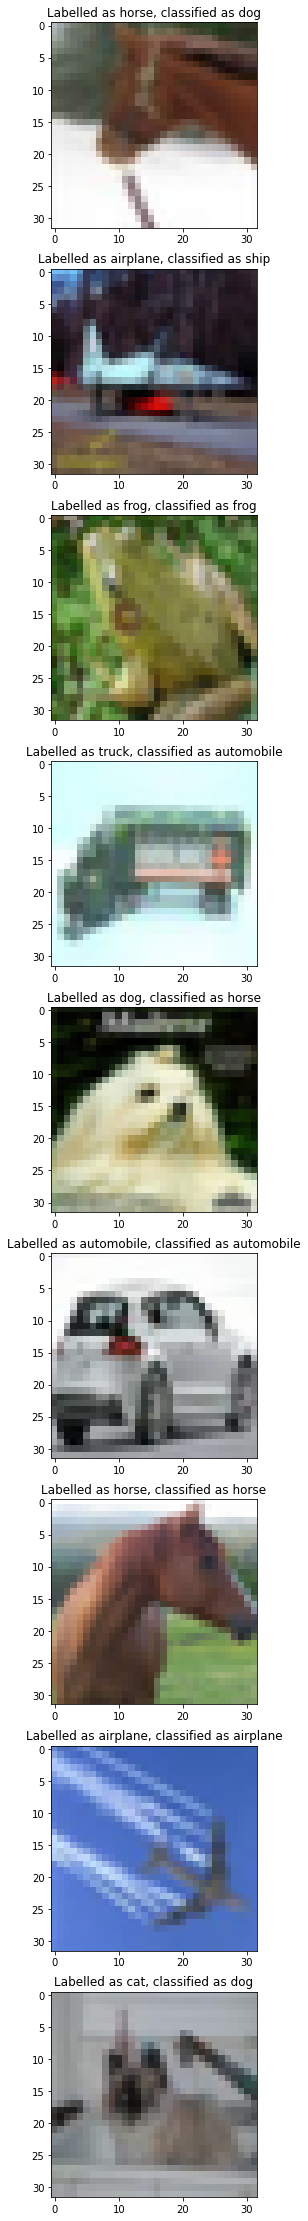

In [5]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

pred = np.argmax(model.predict(test_x), axis = 1)

print("Test Accuracy: {:.2%}".format(np.sum(pred == test_y) / len(test_y)))

sample_data = test_x[: 9]
sample_label = test_y[: 9]

fig = plt.figure(figsize = (10, 40))

for i in range(len(sample_data)):
    ax = fig.add_subplot(911 + i)
    ax.imshow(test_x[i])

    ax.set_title("Labelled as " + labels[int(sample_label[i])] + ", classified as " + labels[int(pred[i])])